In [1]:
library(dplyr)
library(ggplot2)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




# 1.0 Simulations of PM2.5, EGFR mutation and lung cancer

In [ ]:
set.seed(123)

# Simulation function template
simulate <- function(
    n_pop = 1000000,
    lc_base_rate = 0.05,
    egfr_base_rate = 0.1,
    high_pm25_rate = 0.5,
    pm25_egfr_effect = 1,
    pm25_lc_effect = 2,
    egfr_lc_effect = 10,
    pm25_egfr_lc_effect = 1
) {

    library(dplyr)

    # store parameters into a data frame 
    params <- data.frame(
        n_pop = n_pop,
        lc_base_rate = lc_base_rate,
        egfr_base_rate = egfr_base_rate,
        high_pm25_rate = high_pm25_rate,
        pm25_egfr_effect = pm25_egfr_effect,
        pm25_lc_effect = pm25_lc_effect,
        egfr_lc_effect = egfr_lc_effect,
        pm25_egfr_lc_effect = pm25_egfr_lc_effect
    )

    # sample PM2.5 
    PM25 = rbinom(n = n_pop, size = 1, p = high_pm25_rate)

    # sample EGFR 
    logit_p_egfr = qlogis(egfr_base_rate) + PM25 * log(pm25_egfr_effect)
    p_egfr  <- plogis(logit_p_egfr)
    EGFR <- rbinom(n = n_pop, size = 1, p = p_egfr)

    # sample lung cancer 
    logit_p_lc <- qlogis(lc_base_rate) + 
                  log(pm25_lc_effect) * PM25 + 
                  log(egfr_lc_effect) * EGFR + 
                  log(pm25_egfr_lc_effect) * PM25 * EGFR
    p_lc <- plogis(logit_p_lc)
    lc <- rbinom(n_pop, 1, prob = p_lc)

    # summarize the data 
    df <- data.frame(PM25 = PM25,
                     EGFR = EGFR,
                     lc = lc)

    # summarize prevalence 
    smry <- params %>% bind_cols(
        data.frame(
            n_lc = sum(df$lc),
            prev_lc = mean(df$lc),
            prev_lc_egfr = mean(df$lc[df$EGFR == 1]),
            prev_pm25_lc = mean(df$PM25[df$lc == 1])
        )
    )

    # OR per PM2.5 increase on EGFR mutation among LC patients
    glm_fit <- glm(EGFR ~ PM25, data = df %>% filter(lc == 1), family = binomial)
    suppressMessages(
        or <- data.frame(
            or = exp(coef(glm_fit)["PM25"]),
            lower_ci = exp(confint(glm_fit)["PM25", 1]),
            upper_ci = exp(confint(glm_fit)["PM25", 2])
        )
    )

    # combine summary and OR
    out <- bind_cols(smry, or)

    return(out)
}

# Example usage:
simulate()


## 1.1 OR(EGFR|PM25) = 1

In [ ]:
rls <- data.frame()
for(pm25_lc_effect in (c(0.1, 1, 2, 3, 4, 5))){
    rls <- rls %>% bind_rows(
        simulate(pm25_lc_effect = pm25_lc_effect)
    )
}

saveRDS(rls, file = "simple_pm25_lc_effect.rds")


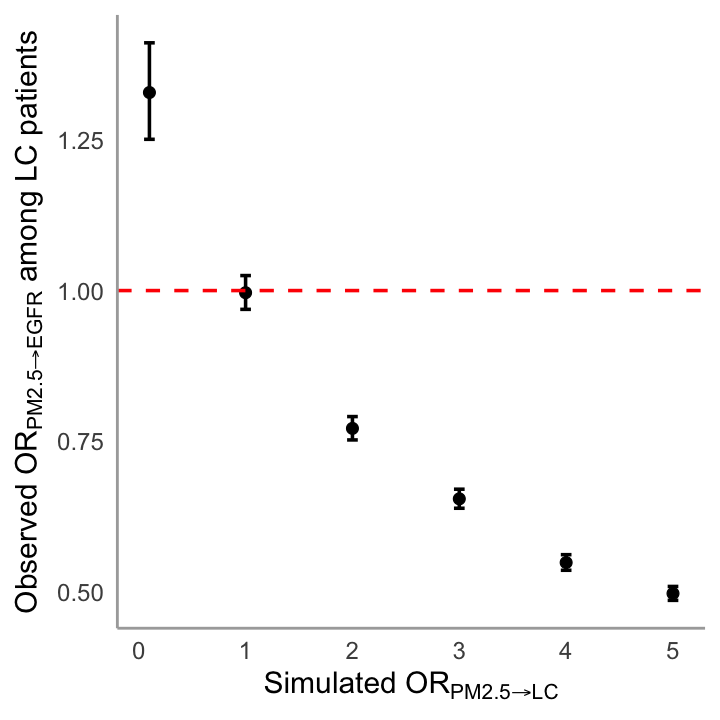

In [2]:
rls <- readRDS("simple_pm25_lc_effect.rds")
true_or <- 1  # if your true pm25_egfr_effect is 1, adjust accordingly


# Plot
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(rls, aes(x = pm25_lc_effect, y = or)) +
    geom_point(size = 3) +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.1, linewidth = 1) +
    geom_hline(yintercept = true_or, color = "red", linetype = "dashed", linewidth = 1) +
    labs(
        x = expression("Simulated OR"[PM2.5 %->% LC]),
        y = expression("Observed OR"[PM2.5 %->% EGFR] * " among LC patients")
    ) + 
    theme_minimal(base_size = 18) +
    theme(
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
		axis.line = element_line(color = "darkgrey", linewidth = 0.8)
    )

saveRDS(rls, file = "simple_pm25_lc_effect.rds")
ggsave("simple_pm25_lc_effect.pdf", width = 6, height = 6)

## 1.2. Fix OR(LC|PM25) = 2, change OR(EGFR|PM25)

In [ ]:
library(dplyr)
library(ggplot2)

# Run simulation
rls <- data.frame()
for (pm25_lc_effect in c(1, 2)) {
    for (pm25_egfr_effect in c(0.1, 1, 2, 3, 4, 5)) {
        rls <- rls %>% bind_rows(
            simulate(pm25_egfr_effect = pm25_egfr_effect, pm25_lc_effect = pm25_lc_effect)
        )
    }
}

rls <- rls %>%
    mutate(pm25_lc_effect_label = case_when(
        pm25_lc_effect == 1 ~ "No effect",
        pm25_lc_effect == 2 ~ "PM2.5 causes LC (OR = 2)"
    ))

saveRDS(rls, file = "simple_pm25_egfr_effect.rds")

Warning message in geom_abline(yintercept = 0, slope = 1, color = "red", linetype = "dashed", :
"Ignoring unknown parameters: `yintercept`"


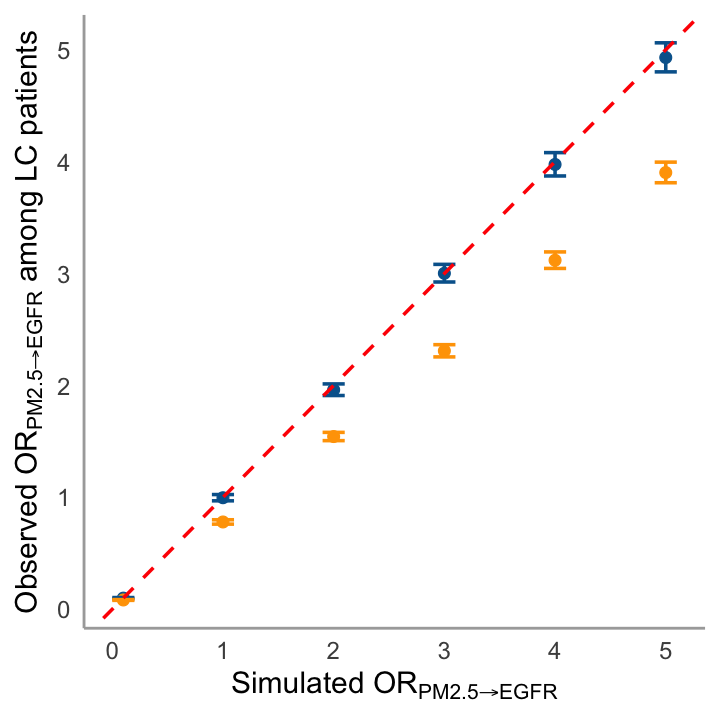

In [3]:
# Plot
rls <- readRDS("simple_pm25_egfr_effect.rds")
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(rls, aes(x = pm25_egfr_effect, y = or, color = pm25_lc_effect_label)) +
    geom_point(size = 3) +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, linewidth = 1) +
    geom_abline(yintercept=0, slope = 1, color = "red", linetype = "dashed", linewidth = 1)+
    labs(
        x =expression("Simulated OR"[PM2.5 %->% EGFR] ),
         y = expression("Observed OR"[PM2.5 %->% EGFR] * " among LC patients"),
        color = expression("True OR"[PM2.5 %->% LC] )  # <-- Add legend title
    ) + scale_color_manual(values = c("#00639b", "#ffa300"))+
    theme_minimal(base_size = 18) +
    theme(
        plot.title = element_text(hjust = 0.5),
        legend.position = "none",
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 12)
    )+
    theme(
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
		axis.line = element_line(color = "darkgrey", linewidth = 0.8)
    )
	ggsave("simple_pm25_egfr_effect.pdf", width = 6, height = 6)

## 1.3. change interaction effect

In [ ]:
library(dplyr)
library(ggplot2)

# Run simulation
rls <- data.frame()
for (pm25_lc_effect in c(1, 2)) {
    for (pm25_egfr_lc_effect in c(0.1, 1, 2, 3, 4, 5)) {
        rls <- rls %>% bind_rows(
            simulate(pm25_egfr_lc_effect = pm25_egfr_lc_effect, pm25_lc_effect = pm25_lc_effect)
        )
    }
}

rls <- rls %>%
    mutate(pm25_lc_effect_label = case_when(
        pm25_lc_effect == 1 ~ "No effect",
        pm25_lc_effect == 2 ~ "PM2.5 causes LC (OR = 2)"
    ))
saveRDS(rls, file = "simple_pm25_egfr_lc_effect.rds")

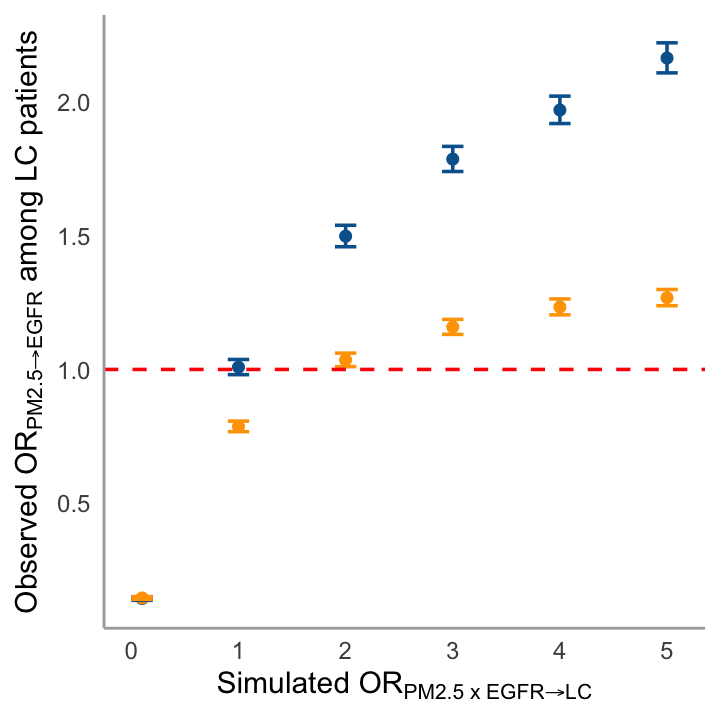

In [4]:
# Plot
rls <- readRDS("simple_pm25_egfr_lc_effect.rds")
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(rls, aes(x =pm25_egfr_lc_effect , y = or, color = pm25_lc_effect_label)) +
    geom_point(size = 3) +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, linewidth = 1) +
    geom_hline(yintercept = true_or, color = "red", linetype = "dashed", linewidth = 1) +
    labs(
        x =expression("Simulated OR"["PM2.5 x EGFR" %->% "LC"]),
        y = expression("Observed OR"[PM2.5 %->% EGFR] * " among LC patients"),
        color = "PM2.5 effect\non LC (pm25_lc_effect)"  # <-- Add legend title
    ) +
    theme_minimal(base_size = 16) +
    theme(
        plot.title = element_text(hjust = 0.5),
        legend.position = "right",
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 12)
    )+ scale_color_manual(values = c("#00639b", "#ffa300"))+
    theme_minimal(base_size = 18) +
    theme(
        plot.title = element_text(hjust = 0.5),
        legend.position = "none",
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 12)
    )+
    theme(
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
		axis.line = element_line(color = "darkgrey", linewidth = 0.8)
    )

ggsave("simple_pm25_egfr_lc_effect.pdf", width = 6, height = 6)


# 2.0 Extended simulations incorporating smoking history and KRAS mutations

In [ ]:
set.seed(1234)

library(dplyr)

# Extended Simulation function template
simulate_extended <- function(
    n_pop = 1000000,
    lc_base_rate = 0.1,
    high_pm25_rate = 0.5,
    smoking_rate = 0.5,
    egfr_base_rate = 0.1,
    kras_base_rate = 0.1,
    smoking_kras_effect = 4,
    pm25_egfr_effect = 1,
    pm25_lc_effect = 2,
    smoking_lc_effect = 4,
    egfr_lc_effect = 10,
    kras_lc_effect = 10,
    pm25_egfr_lc_effect = 1
) {

    # Store parameters
    params <- data.frame(
        n_pop = n_pop,
        lc_base_rate = lc_base_rate,
        egfr_base_rate = egfr_base_rate,
        kras_base_rate = kras_base_rate,
        high_pm25_rate = high_pm25_rate,
        smoking_rate = smoking_rate,
        smoking_kras_effect = smoking_kras_effect,
        pm25_egfr_effect = pm25_egfr_effect,
        pm25_lc_effect = pm25_lc_effect,
        smoking_lc_effect = smoking_lc_effect,
        egfr_lc_effect = egfr_lc_effect,
        kras_lc_effect = kras_lc_effect,
        pm25_egfr_lc_effect = pm25_egfr_lc_effect
    )

    # Simulate exposure and behavior
    PM25 <- rbinom(n = n_pop, size = 1, p = high_pm25_rate)
    Smoking <- rbinom(n = n_pop, size = 1, p = smoking_rate)

    # KRAS mutation probability (depends on smoking)
    logit_p_kras = qlogis(kras_base_rate) + log(smoking_kras_effect) * Smoking
    p_kras <- plogis(logit_p_kras)
    KRAS <- rbinom(n = n_pop, size = 1, p = p_kras)

    # EGFR mutation probability (only if KRAS == 0)
    logit_p_egfr = qlogis(egfr_base_rate) + log(pm25_egfr_effect) * PM25 + log(0.1) * KRAS
    p_egfr <- plogis(logit_p_egfr)
	EGFR <- rbinom(n = n_pop, size = 1, p = p_egfr)

    # Lung Cancer risk
    logit_p_lc <- qlogis(lc_base_rate) + 
                  log(pm25_lc_effect) * PM25 + 
                  log(smoking_lc_effect) * Smoking + 
                  log(egfr_lc_effect) * EGFR + 
                  log(kras_lc_effect) * KRAS + 
                  log(pm25_egfr_lc_effect) * PM25 * EGFR
    p_lc <- plogis(logit_p_lc)
    LC <- rbinom(n_pop, 1, prob = p_lc)

    # Create DataFrame
    df <- data.frame(PM25 = PM25, Smoking = Smoking, EGFR = EGFR, KRAS = KRAS, LC = LC)

    # Summarize prevalence
    smry <- params %>% bind_cols(
        data.frame(
            n_lc = sum(df$LC),
            prev_lc = mean(df$LC),
            prev_lc_egfr = mean(df$LC[df$EGFR == 1]),
            prev_lc_kras = mean(df$LC[df$KRAS == 1]),
            prev_pm25_lc = mean(df$PM25[df$LC == 1]),
            prev_smoking_lc = mean(df$Smoking[df$LC == 1])
        )
    )

    # OR of PM2.5 on EGFR among LC patients
    glm_fit_egfr <- glm(EGFR ~ PM25 + Smoking + KRAS, data = df %>% filter(LC == 1), family = binomial)
    suppressMessages(
        or_egfr_all <- data.frame(
            group = 'all',
            or = exp(coef(glm_fit_egfr)["PM25"]),
            lower_ci = exp(confint(glm_fit_egfr)["PM25", 1]),
            upper_ci = exp(confint(glm_fit_egfr)["PM25", 2])
        )
    )
	
    
    glm_fit_egfr <- glm(EGFR ~ PM25 + KRAS, data = df %>% filter(LC == 1, Smoking == 1), family = binomial)
    suppressMessages(
        or_egfr_s <- data.frame(
            group = 's',
            or = exp(coef(glm_fit_egfr)["PM25"]),
            lower_ci = exp(confint(glm_fit_egfr)["PM25", 1]),
            upper_ci = exp(confint(glm_fit_egfr)["PM25", 2])
        )
    )
    
    glm_fit_egfr <- glm(EGFR ~ PM25 + KRAS, data = df %>% filter(LC == 1, Smoking == 0), family = binomial)
    suppressMessages(
        or_egfr_ns <- data.frame(
            group = 'ns',
            or = exp(coef(glm_fit_egfr)["PM25"]),
            lower_ci = exp(confint(glm_fit_egfr)["PM25", 1]),
            upper_ci = exp(confint(glm_fit_egfr)["PM25", 2])
        )
    )
    
    rm(df)
    # Combine results
    out <- bind_cols(smry, bind_rows(or_egfr_all, or_egfr_ns, or_egfr_s))

    return(out)
}

# Example usage:
# simulate_extended()


## OR(EGFR|PM25) = 1

In [ ]:
rls <- data.frame()
for(pm25_lc_effect in (c(0.1,1,2,3,4,5))){
    rls <- rls %>% bind_rows(
        simulate_extended(pm25_lc_effect = pm25_lc_effect)
    )
}
saveRDS(rls, file = "comprehensive_pm25_lc_effect.rds")

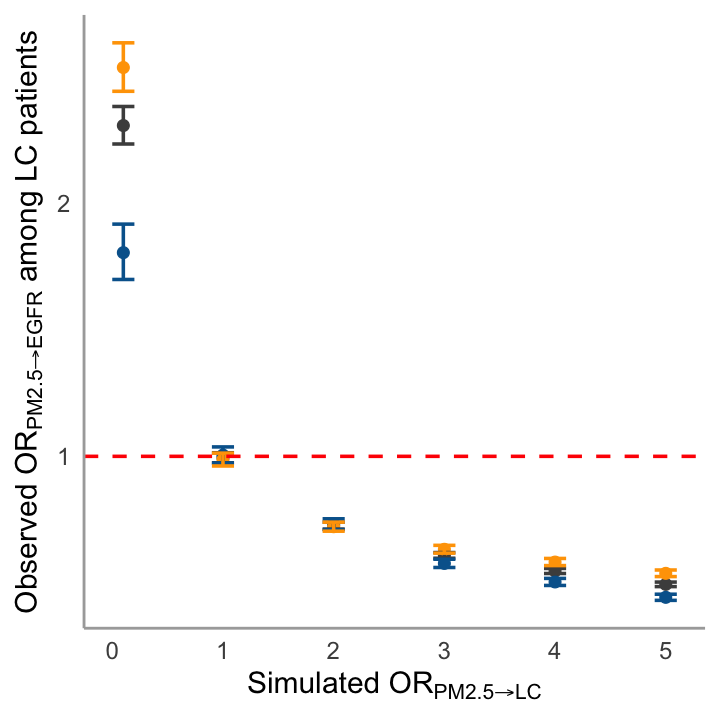

In [5]:
rls <- readRDS("comprehensive_pm25_lc_effect.rds")
# Set true OR based on the true pm25_egfr_effect you simulated
true_or <- 1  # if your true pm25_egfr_effect is 1, adjust accordingly


# Plot
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(rls, aes(x = pm25_lc_effect, y = or, color = group)) +
    geom_point(size = 3) +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, linewidth = 1) +
    geom_hline(yintercept = true_or, color = "red", linetype = "dashed", linewidth = 1) +
    labs(
        x = expression("Simulated OR"[PM2.5 %->% LC]),
        y = expression("Observed OR"[PM2.5 %->% EGFR] * " among LC patients")
    ) + scale_color_manual(values = c("#4D4D4D", "#00639b", "#ffa300"), labels = c('All', 'Never-smokers', 'Smokers'))+
    theme_minimal(base_size = 18) +
    theme(
        plot.title = element_text(hjust = 0.5),
        legend.position = "none",
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 12)
    )+
    theme(
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
		axis.line = element_line(color = "darkgrey", linewidth = 0.8)
    )
	ggsave("comprehensive_pm25_lc_effect.pdf", width = 6, height = 6)


## 2.2 Fix OR(LC|PM25) = 2, change OR(EGFR|PM25)

In [ ]:
library(dplyr)
library(ggplot2)

# Run simulation
rls <- data.frame()
for (pm25_lc_effect in c(1,2)) {
    for (pm25_egfr_effect in c(0.1,1,2,3,4,5)) {
        rls <- rls %>% bind_rows(
            simulate_extended(pm25_egfr_effect = pm25_egfr_effect, pm25_lc_effect = pm25_lc_effect)
        )
    }
}

rls <- rls %>%
    mutate(pm25_lc_effect_label = case_when(
        pm25_lc_effect == 1 ~ "No effect",
        pm25_lc_effect == 2 ~ "PM2.5 causes LC (OR = 2)"
    ))
saveRDS(rls, file = "comprehensive_pm25_egfr_effect.rds")

In [ ]:
# Plot
rls <- readRDS("comprehensive_pm25_egfr_effect.rds")
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(rls %>% filter(pm25_lc_effect == 1), aes(x = pm25_egfr_effect, y = or, color = group)) +
    geom_point(size = 3) +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, linewidth = 1) +
    geom_abline(yintercept=0, slope = 1, color = "red", linetype = "dashed", linewidth = 1)+
    labs(
       x =expression("Simulated OR"[PM2.5 %->% EGFR] ),
         y = expression("Observed OR"[PM2.5 %->% EGFR] * " among LC patients"),
    ) +theme_minimal(base_size = 18) +
scale_color_manual(values = c("#4D4D4D", "#00639b", "#ffa300"), labels = c('All', 'Never-smokers', 'Smokers')) + 
    theme(
        plot.title = element_text(hjust = 0.5),
        legend.position = "none",
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 12)
    )+
    theme(
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
		axis.line = element_line(color = "darkgrey", linewidth = 0.8)
    ) + ylim(0,5.2) + xlim(0,5)
	ggsave("comprehensive_pm25_egfr_effect_null.pdf", width = 6, height = 6)

Warning message in geom_abline(yintercept = 0, slope = 1, color = "red", linetype = "dashed", :
"Ignoring unknown parameters: `yintercept`"


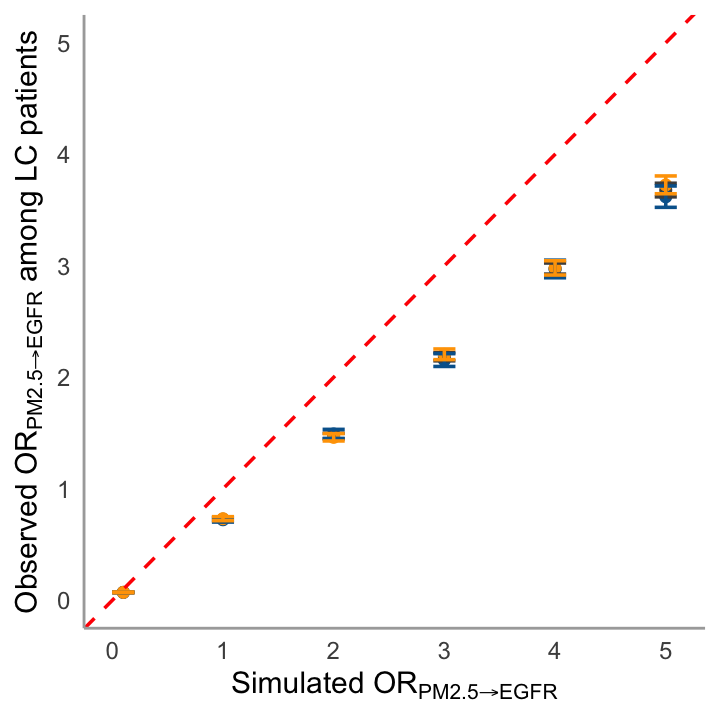

In [6]:
# Plot
rls <- readRDS("comprehensive_pm25_egfr_effect.rds")
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(rls %>% filter(pm25_lc_effect == 2), aes(x = pm25_egfr_effect, y = or, color = group)) +
    geom_point(size = 3) +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, linewidth = 1) +
    geom_abline(yintercept=0, slope = 1, color = "red", linetype = "dashed", linewidth = 1)+
    labs(
       x =expression("Simulated OR"[PM2.5 %->% EGFR] ),
         y = expression("Observed OR"[PM2.5 %->% EGFR] * " among LC patients"),
    ) +theme_minimal(base_size = 18) +
scale_color_manual(values = c("#4D4D4D", "#00639b", "#ffa300"), labels = c('All', 'Never-smokers', 'Smokers')) + 
    theme(
        plot.title = element_text(hjust = 0.5),
        legend.position = "none",
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 12)
    )+
    theme(
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
		axis.line = element_line(color = "darkgrey", linewidth = 0.8)
    ) + ylim(0,5)
	ggsave("comprehensive_pm25_egfr_effect_causal.pdf", width = 6, height = 6)

In [ ]:
## 2.3 Change interaction effect

In [ ]:
library(dplyr)
library(ggplot2)

# Run simulation
rls <- data.frame()
for (pm25_lc_effect in c(1, 2)) {
    for (pm25_egfr_lc_effect in c(0.1, 1, 2, 3, 4, 5)) {
        rls <- rls %>% bind_rows(
            simulate_extended(pm25_egfr_lc_effect = pm25_egfr_lc_effect, pm25_lc_effect = pm25_lc_effect)
        )
    }
}

rls <- rls %>%
    mutate(pm25_lc_effect_label = case_when(
        pm25_lc_effect == 1 ~ "No effect",
        pm25_lc_effect == 2 ~ "PM2.5 causes LC (OR = 2)"
    ))
saveRDS(rls, file = "comprehensive_pm25_egfr_lc_effect.rds")

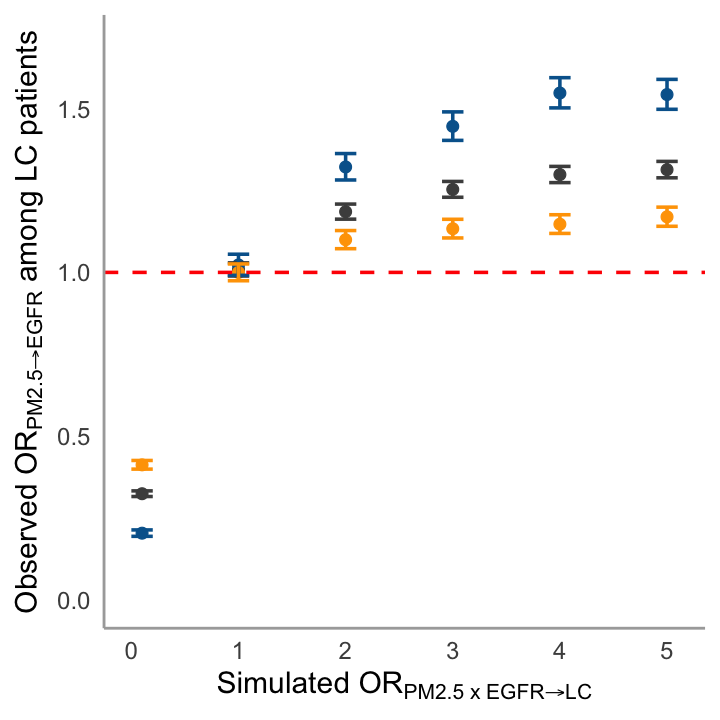

In [7]:
# Plot
rls <- readRDS("comprehensive_pm25_egfr_lc_effect.rds")
true_or = 1
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(rls %>% filter(pm25_lc_effect == 1), aes(x = pm25_egfr_lc_effect, y = or, color = group)) +
    geom_point(size = 3) +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, linewidth = 1) +
geom_hline(yintercept = true_or, color = "red", linetype = "dashed", linewidth = 1) +
    labs(
      x = expression("Simulated OR"["PM2.5 x EGFR" %->% "LC"]),
         y = expression("Observed OR"[PM2.5 %->% EGFR] * " among LC patients")
    ) +theme_minimal(base_size = 18) +
scale_color_manual(values = c("#4D4D4D", "#00639b", "#ffa300"), labels = c('All', 'Never-smokers', 'Smokers')) + 
    theme(
        plot.title = element_text(hjust = 0.5),
        legend.position = "none",
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 12)
    )+
    theme(
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
		axis.line = element_line(color = "darkgrey", linewidth = 0.8)
	) + ylim(0,1.7)
	ggsave("comprehensive_pm25_egfr_lc_effect_null.pdf", width = 6, height = 6)


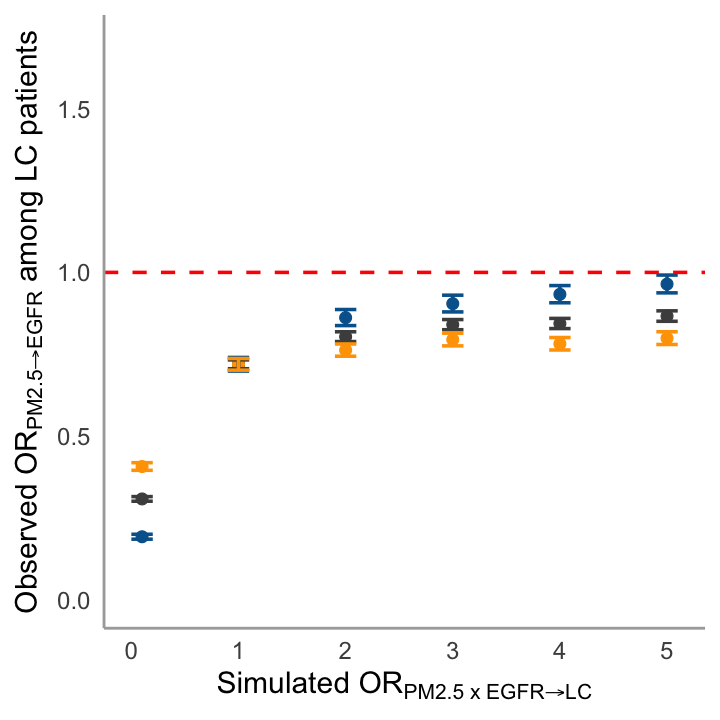

In [8]:
# Plot
rls <- readRDS("comprehensive_pm25_egfr_lc_effect.rds")
true_or = 1
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(rls %>% filter(pm25_lc_effect == 2), aes(x = pm25_egfr_lc_effect, y = or, color = group)) +
    geom_point(size = 3) +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, linewidth = 1) +
geom_hline(yintercept = true_or, color = "red", linetype = "dashed", linewidth = 1) +
    labs(
      x = expression("Simulated OR"["PM2.5 x EGFR" %->% "LC"]),
         y = expression("Observed OR"[PM2.5 %->% EGFR] * " among LC patients")
    ) +theme_minimal(base_size = 18) +
scale_color_manual(values = c("#4D4D4D", "#00639b", "#ffa300"), labels = c('All', 'Never-smokers', 'Smokers')) + 
    theme(
        plot.title = element_text(hjust = 0.5),
        legend.position = "none",
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 12)
    )+
    theme(
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
		axis.line = element_line(color = "darkgrey", linewidth = 0.8)
	) + ylim(0,1.7)
	ggsave("comprehensive_pm25_egfr_lc_effect_causal.pdf", width = 6, height = 6)
